In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

In [94]:
dict_df = {}

# read all energy history files (regex to get all files)
for file in glob.glob("../output/energy_history_*.csv"):
    df = pd.read_csv(file)
    dict_df[file] = df

In [95]:
df = df.drop(columns=df.filter(regex="^User").columns)
df.head()

,Base Station 0,Base Station 1,Base Station 2,Base Station 3,HAPS 0,LEO 0
0,5.0,5.0,5.0,5.0,5.0,5.0
1,5.0,5.0,5.0,5.0,5.0,5.0
2,5.0,5.0,5.0,5.0,5.0,5.0
3,5.0,5.0,5.0,5.0,5.0,5.0
4,5.0,5.0,5.0,5.0,5.0,5.0


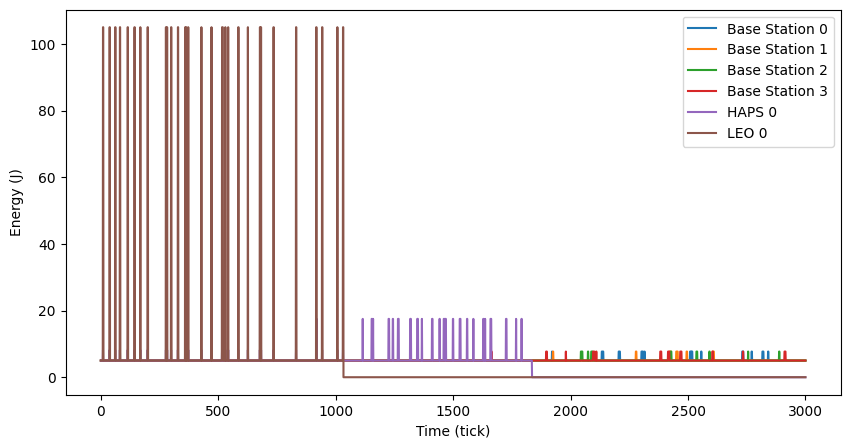

In [96]:
df.plot(kind="line", figsize=(10, 5))
plt.xlabel("Time (tick)")
plt.ylabel("Energy (J)")
plt.show()

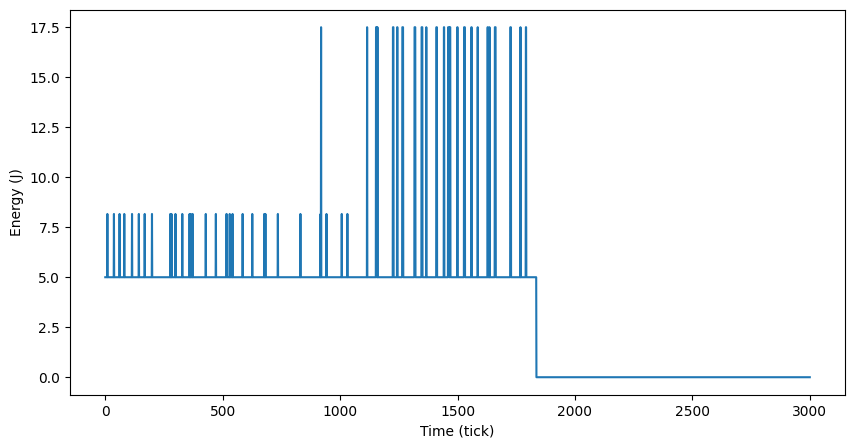

In [97]:
df = df["HAPS 0"]

df.plot(kind="line", figsize=(10, 5))
plt.xlabel("Time (tick)")
plt.ylabel("Energy (J)")
plt.show()

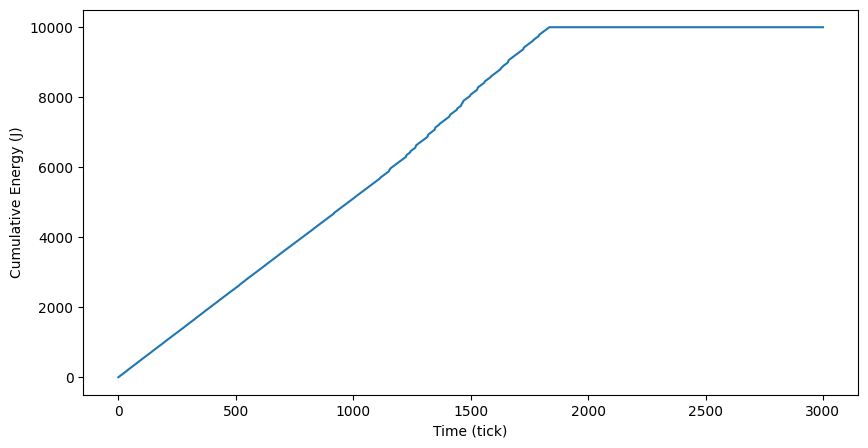

In [98]:
cum_df = df.cumsum()

cum_df.plot(kind="line", figsize=(10, 5))
plt.xlabel("Time (tick)")
plt.ylabel("Cumulative Energy (J)")
plt.show()